In [1]:
import os

os.environ["DGLBACKEND"] = "pytorch" 
import dgl
from dgl.data import CoraGraphDataset
import dgl.function as fn
import torch
import torch.nn as nn
from torch.nn import init
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

/home/zhura/miniconda3/envs/torch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def load_data_dgl():
    """Load citation network dataset using DGL"""
    print('Loading Cora dataset...')

    # 使用 DGL 加载 Cora 数据集
    dataset = CoraGraphDataset()
    graph = dataset[0]
    N = graph.number_of_nodes()  # 节点数

    # 获取节点特征和标签
    features = graph.ndata['feat']
    # features = normalize_features(features.numpy())  # 归一化特征
    labels = graph.ndata['label']

    # 获取训练、验证和测试集的索引
    train_mask = graph.ndata['train_mask']
    val_mask = graph.ndata['val_mask']
    test_mask = graph.ndata['test_mask']

    # 转换为 PyTorch 张量
    features = torch.FloatTensor(features)
    labels = torch.LongTensor(labels)

    # 获取边属性（邻接矩阵）
    adj = graph.adjacency_matrix().to_dense()
    adj = torch.FloatTensor(adj.numpy())
    #NOTE: 为图的边赋予新的三维属性
    edge_attr = [adj, adj.t(), adj + adj.t()] # 这里人为构建一个3维的边属性 [3 * N * N]
    edge_attr = torch.stack(edge_attr, dim=0)
    edge_attr = DSN(edge_attr) # 双随机归一化
    edge_attr_reshaped = edge_attr[:, graph.edges()[0], graph.edges()[1]]
    graph.edata['feat'] = edge_attr_reshaped.t()

    return graph, edge_attr, features, labels, train_mask, val_mask, test_mask

def DSN2(t):
    a=t.sum(dim=1,keepdim=True)
    b=t.sum(dim=0,keepdim=True)
    lamb=torch.cat([a.squeeze(),b.squeeze()],dim=0).max()
    r=t.shape[0]*lamb-t.sum(dim=0).sum(dim=0)
    
    a=a.expand(-1,t.shape[1])
    b=b.expand(t.shape[0],-1)
    tt=t+(lamb**2-lamb*(a+b)+a*b)/r

    ttmatrix=tt/tt.sum(dim=0)[0]
    ttmatrix=torch.where(t>0,ttmatrix,t)
    return ttmatrix


def DSN(x):
    """Doubly stochastic normalization"""
    p=x.shape[0]
    y1=[]
    for i in range(p):
        y1.append(DSN2(x[i]))
    y1=torch.stack(y1,dim=0)
    return y1


In [3]:
g, edge_attr, features, labels, train_mask, val_mask, test_mask = load_data_dgl()

Loading Cora dataset...
  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


In [4]:
print("Node features")
print(g.ndata)
print("Edge features")
print(g.edata)

Node features
{'feat': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]), 'label': tensor([3, 4, 4,  ..., 3, 3, 3]), 'test_mask': tensor([False, False, False,  ...,  True,  True,  True]), 'val_mask': tensor([False, False, False,  ..., False, False, False]), 'train_mask': tensor([ True,  True,  True,  ..., False, False, False])}
Edge features
{'feat': tensor([[0.0063, 0.0063, 0.0063],
        [0.0063, 0.0063, 0.0063],
        [0.0063, 0.0063, 0.0063],
        ...,
        [0.0062, 0.0062, 0.0062],
        [0.0063, 0.0063, 0.0063],
        [0.0063, 0.0063, 0.0063]])}


\begin{equation}
X^l=\sigma\left[\|_{p=1}^P\left(\alpha_{. \cdot p}^l\left(X^{l-1}, E_{\cdot \cdot p}^{l-1}\right) g^l\left(X^{l-1}\right)\right)\right] .
\end{equation}

\begin{align}
g^l\left(X^{l-1}\right)=W^l X^{l-1},\\
f^l\left(X_{i \cdot}^{l-1}, X_{j .}^{l-1}\right)=\exp \left\{\mathrm{L}\left(a^T\left[W X_{i \cdot}^{l-1} \| W X_{j .}^{l-1}\right]\right)\right\}\\
\alpha_{\cdot \cdot p}^l=\operatorname{DS}\left(\hat{\alpha}_{\cdot \cdot p}^l\right),\\
\hat{\alpha}_{i j p}^l=f^l\left(X_{i .}^{l-1}, X_j^{l-1}\right) E_{i j p}^{l-1},\\
E^l=\alpha^l
\end{align}

In [ ]:
class EGNNA_Conv(nn.Module):
    def __init__(self, 
                 dim_in:int, # 输入h的特征维度
                 dim_h:int, # 各节点h的l+1层特征维度
                 dropout:float,
                 node_att_agger: bool = False # 最后节点特征是N*(F*P) 还是聚合为 N*F
                 ):
        super(EGNNA_Conv, self).__init__()
        self.dropout = dropout
        self.fc_w = nn.Linear(dim_in, dim_h,bias=True) # W
        self.fc_ai = nn.Linear(dim_h,1,bias=False) # a_i
        self.fc_aj = nn.Linear(dim_h,1,bias=False) # a_j
        self.leakyrelu = nn.LeakyReLU(0.2) #NOTE: negative_slope=0.2
        self.node_att_agger = node_att_agger
        self.reset_parameters()
        
    def reset_parameters(self):
        """
        Reinitialize learnable parameters.
        """
        gain = init.calculate_gain('relu')
        init.xavier_normal_(self.fc_w.weight, gain=gain)
        init.xavier_normal_(self.fc_ai.weight, gain=gain)
        init.xavier_normal_(self.fc_aj.weight, gain=gain)
    
    def forward(self, h, e):
        '''
        INPUT:
        h: node_feature  shape = [N * dim_node_features]
        e: edge_feature shape = [dim_edge_features * N * N]
        
        OUTPUT:
        new_h : new node feature shape = [N * (dim_node_features*dim_edge_features)]
        alpha: new edge feature shape = [dim_edge_features * N * N]
        
        '''
        # 用FC1先算W @ h
        Wh = self.fc_w(h) # N * dim_out_features
        # 计算注意力系数(N * N )
        fXX = self.leakyrelu(self.fc_ai(Wh) + self.fc_aj(Wh).t()) # N * N
        # fXX = torch.exp(fXX)
        alpha = fXX * e # 广播点乘 [N * N]  .*  [P * N * N] .= [P * N * N]
        #NOTE: 由于双随机归一化DS()操作难以实现，这里直接对alpha进行softmax归一化求注意力系数
        alpha = torch.where(e>0, alpha, -9e15*torch.ones_like(alpha)) # 将不存在的边的注意力系数设置为0
        alpha = F.softmax(alpha, dim=1) # 对每个节点的所有邻居进行softmax
        
        #NOTE: alpha := new edge feature (e)
        
        attention = F.dropout(alpha, self.dropout, training=self.training) # dropout
        # [P, N, F]
        new_h = torch.empty((e.shape[0], Wh.shape[0], Wh.shape[1]), device=Wh.device)
        for i in range(e.shape[0]):
            new_h[i] = torch.matmul(attention[i], Wh)
        
        if not self.node_att_agger:
            new_h = new_h.permute(1,2,0).reshape(new_h.shape[1], -1) # N * (P * F)
            
            return F.elu(new_h), alpha
        
        else:
            new_h = torch.sum(new_h, dim=0) # N * F
            
            return new_h

In [6]:
class MultiHead_EGNNA_Classifier(nn.Module):
    def __init__(self,
                 dim_nfeat:int, 
                 dim_efeat:int, # P
                 dim_hidden:int, # for [input_layer, hidden_layer]
                 dim_out:int,# for output_layer
                 dropout:float,
                 n_heads:int # for [input_layer, hidden_layer]
                 ):
        super(MultiHead_EGNNA_Classifier, self).__init__()
        self.dropout = dropout
        
        # Multi-head attention mechanism
        # 1. input layer
        self.attentions = [EGNNA_Conv(dim_nfeat, dim_hidden[0], dropout)
                           for _ in range(n_heads[0])]
        for i, attention in enumerate(self.attentions):
            self.add_module('attention_{}'.format(i), attention)
            
        # 2. Hidden layer
        self.hidden_atts = [EGNNA_Conv(n_heads[0]*dim_efeat*dim_hidden[0],
                                       dim_hidden[1], dropout)
                            for _ in range(n_heads[1])]
        for i, hidden_att in enumerate(self.hidden_atts):
            self.add_module('hidden_att_{}'.format(i), hidden_att)
        
        # 3. Output layer
        self.out_att = EGNNA_Conv(n_heads[0]*dim_efeat*dim_hidden[0],
                                  dim_out, dropout, node_att_agger=True)
        
    def forward(self,  h, e):
        
        # Input layer
        h = F.dropout(h, self.dropout, training=self.training)
        temp_h = []
        for att in self.attentions:
            h_, e = att( h, e)
            temp_h.append(h_)
        h = torch.cat(temp_h, dim=1)
            
        # Hidden layer
        h = F.dropout(h, self.dropout, training=self.training)
        temp_h = []
        for att in self.hidden_atts:
            h_, e = att( h, e)
            temp_h.append(h_)
        h = torch.cat(temp_h, dim=1)
        
        # Output layer
        h = F.dropout(h, self.dropout, training=self.training)
        h = F.elu(self.out_att( h, e)) # 输出各分类的得分情况
        
        return h
        

In [7]:
model = MultiHead_EGNNA_Classifier(dim_nfeat=features.shape[1],
                                   dim_efeat=edge_attr.shape[0],
                                   dim_hidden=[64,8],
                                   dim_out=int(labels.max()) + 1,
                                   dropout=0.6,
                                   n_heads=[1,8]
)

In [8]:
seed = 99

np.random.seed(seed)
torch.manual_seed(seed)

if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    model.cuda()
    features = features.cuda()
    edge_attr = edge_attr.cuda()
    labels = labels.cuda()
    train_mask = train_mask.cuda()
    val_mask = val_mask.cuda()
    test_mask = test_mask.cuda()


In [9]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
best_val_acc = 0
best_test_acc = 0

train_losses = []
val_accuracies = []
test_accuracies = []

num_epochs = 500

for e in range(num_epochs):
    # set model to training mode  
    model.train()
    logits = model(features, edge_attr)
    pred = logits.argmax(1) # 返回得分最大的索引
    train_acc = (pred[train_mask] == labels[train_mask]).float().mean()
    val_acc = (pred[val_mask] == labels[val_mask]).float().mean()
    loss = F.cross_entropy(logits[train_mask], labels[train_mask])
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    model.eval()
    logits = model(features, edge_attr)
    pred = logits.argmax(1)
    test_acc = (pred[test_mask] == labels[test_mask]).float().mean()
    
    train_losses.append(loss.item())
    val_accuracies.append(val_acc.item())
    test_accuracies.append(test_acc.item())

    if best_val_acc < val_acc:
        best_val_acc = val_acc
        best_test_acc = test_acc
        pass
    
    if e % 5 == 0:
        print(
            f"In epoch {e}, loss: {loss:.3f}, val acc: {val_acc:.3f} (best {best_val_acc:.3f}), test acc: {test_acc:.3f} (best {best_test_acc:.3f})"
        )

In epoch 0, loss: 2.212, val acc: 0.128 (best 0.128), test acc: 0.130 (best 0.130)
In epoch 5, loss: 1.861, val acc: 0.196 (best 0.196), test acc: 0.386 (best 0.386)
In epoch 10, loss: 1.712, val acc: 0.256 (best 0.282), test acc: 0.378 (best 0.305)
In epoch 15, loss: 1.371, val acc: 0.410 (best 0.410), test acc: 0.676 (best 0.676)
In epoch 20, loss: 0.962, val acc: 0.550 (best 0.550), test acc: 0.638 (best 0.638)
In epoch 25, loss: 0.690, val acc: 0.600 (best 0.600), test acc: 0.757 (best 0.757)
In epoch 30, loss: 0.663, val acc: 0.616 (best 0.620), test acc: 0.722 (best 0.776)
In epoch 35, loss: 0.508, val acc: 0.610 (best 0.620), test acc: 0.740 (best 0.776)
In epoch 40, loss: 0.417, val acc: 0.618 (best 0.628), test acc: 0.756 (best 0.763)
In epoch 45, loss: 0.468, val acc: 0.650 (best 0.660), test acc: 0.776 (best 0.766)
In epoch 50, loss: 0.423, val acc: 0.636 (best 0.660), test acc: 0.734 (best 0.766)
In epoch 55, loss: 0.381, val acc: 0.644 (best 0.660), test acc: 0.751 (best 0

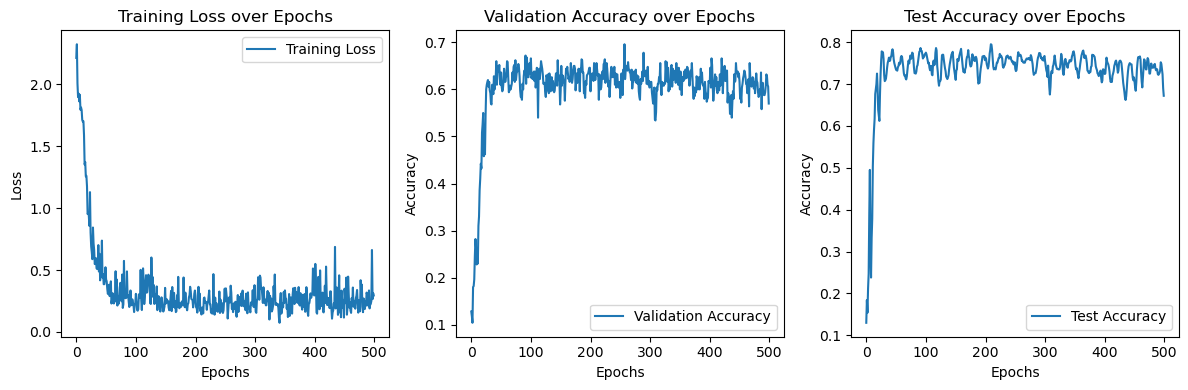

In [10]:
# Plotting the collected metrics
plt.figure(figsize=(12, 4))

# Plot training loss
plt.subplot(1, 3, 1)
plt.plot(range(num_epochs), train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()

# Plot validation accuracy
plt.subplot(1, 3, 2)
plt.plot(range(num_epochs), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy over Epochs')
plt.legend()

# Plot test accuracy
plt.subplot(1, 3, 3)
plt.plot(range(num_epochs), test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Test Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()